# CFAR_COGA HIV Acquisition GWAS

__Author__: Jesse Marks <br>
**GitHub Issue**: [#133](https://github.com/RTIInternational/bioinformatics/issues/133)

This notebook documents the steps to perform a baseline (1df) GWAS on the combined CFAR+COGA EA data. The starting place for this analysis is with the post-QC imputed genotype data. See the processing details for that in Jesse Marks' notebook titled `20191111_hiv_acquisition_cfar_coga_imputation_and_phenotype_construction.ipynb` for the processing details on the phenotype contruction.

**Data Locations**
* Phenotype Data: `s3://rti-hiv/cfar_coga/data/phenotype/final`
* Imputed Genotype Data: `s3://rti-hiv/cfar_coga/data/genotype/imputed/ea`

## Data Description

### phenotype data 
| Ancestry 	| Case 	| Control 	|
|----------	|------	|---------	|
| EA       	| 2409   	| 2414      	|


``

```
	iid, hiv, age, sex, alcohol, PC1, PC3, PC7
```


## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* [ProbABEL](https://github.com/GenABEL-Project/ProbABEL)

**Note** about ProbABEL.
* If you use logistic model, your phenotype must be either 0 or 1 (not 1 or 2). 
* If you include any covariate that does not vary, you will get no results. Example, for WIHS there are no males therefore you cannot include `sex` as a covariate.

# Download Data and Create Directory Structure

In [ ]:
### create directory structure ###
### Download data & unzip ###
cd /shared/jmarks/hiv/wihs3/phenotype/final/
aws s3 sync s3://rti-hiv/wihs3/data/phenotype/ .

# Start GWAS: ProbABEL 

Note that we already prepared the phenotype files.

**Genotype Processing and GWAS Pipeline**
This is an automated pipeline for preparing the genotype data for a GWAS using the ProbABEL tool. The steps in this pipeline are:

1. Merge chrX
    * The chrX imputed data from the Michigan Imputation Server is split between males and females. We need to merge these data for the GWAS because the other data is not split by sex. We control for that with a sex covariate.
2. Convert imputed data format
    * The ProbABEL software requires the data to be formatted differently than the VCF format that is the output from MIS. In particular, we need to convert the VCF files (dosage) to MaCH format.
3. Prune imputed data
    * Prune the imputed data to only the subjects with phenotype data
4. Reorder phenotype file 
    * order the subjects in phenotype file to be the same order as the genotype data (takes less memory to reorder the phenotype file rather than all of the genotype files)
5. Create legend file
6. Reformat info file

<br>
<br>

**Note1:** that the genomic data need to be inflated after they have been download from the Michigan Imputation Server.

**Note2:** this pipeline will perform the actual GWAS (1df and 2df) as well. For the 2df analysis, you might have to adjust the `interaction` parameter in the ProbABEL command. The number you provide should be the number of columns to the right of the phenotype variable that the interaction variable is in your phenotype file. For example, the interaction variable is currently coded as 2 in this pipeline for the 2df GWAS. It is coded as a 2 because we are wanting to perform a GxSex analysis for the 2df GWAS and the sex variable `gender` is two columns to the right of the phenotype variable `hiv` in the phenotype file.

```
iid hiv age gender PC10 PC9 PC2 PC6
109@1064714572_109@1064714572 0 26 1 0.0011 0.0075 0.0039 -3e-04
202@1064714531_202@1064714531 0 27 0 0.0093 -0.0112 0.0023 0.0017
312@1064714548_312@1064714548 0 34 1 -0.0012 -0.0012 4e-04 0.0173
378@1064610814_378@1064610814 0 30 1 0.0113 0.0016 0.0026 0.0043
```

**Note3:** pay close attention to the variables above the double octothorpe line. Be sure to edit them accordingly, like for example the `ancestry, covars` and the `phenotype_file` variables. The `s3_upload` variable should be changed per study as well.

**Note4:** we recommend running the first set of functions first, and then when they finish go on to set number two. This is because the first set of functions do not require as much memory as the second set of functions. For the first set of functions, use a smaller compute node (e.g. the m5.large) and then use a memory intensive compute node (e.g. x1e.2xlarge).

**Note5:** compute the chromosomes in batches. For ProbABEL to run, one needs to decompress the chromosomes. This can create storage issues; chromosomes 2 decompressed for the UHS1234 AA group is 92GB! It is therefore advised to process just a few chromosomes at a time so as not to run into storage issues. 
## code

In [ ]:
## bash script ##
chr=$1  # command line argument (chromosome number)

ancestry="ea"
covars="sex,age,alcohol,PC1,PC3,PC7"  # comma separated (e.g. sex,age,PC3,PC2)
study="cfar_coga"
version="001"  # gwas attempt/version (e.g. 001)
probabel="palogist" # palogist (logistic) or palinear (linear)
one_sex="" # if only one sex to process (for chr23)

baseD=/shared/jmarks/hiv/cfar_coga
imputeD=$baseD/genotype/imputed/final/$ancestry
phenD=$baseD/phenotype/final
procD=$baseD/gwas/1df/$ancestry/$version # output of 1df test and log files
#procD2=$baseD/gwas/2df/$ancestry/$version # output for 2df test

phenotype_file=$phenD/cfar_coga_ea_hiv_age_sex_alcohol_PC1_PC3_PC7.txt
pheno_order=$phenD/phenotype_ids_${ancestry} # list of ids extracted from the phenotype file 

## path to the order of the subject IDs in the pruned genotype files 
## (output from reording genotype files with python script)
id_order=$baseD/genotype/imputed/$ancestry/mach/chr$chr/chr$chr.genotype.id.order  

## where to upload the genotype data after GWAS are complete 
s3_upload=s3://rti-hiv/cfar_coga/data/genotype/imputed/final/$ancestry/probabel/chr$chr/

if [ $ancestry == "aa" ]; then
    group=afr
elif [ $ancestry == "ea" ]; then
    group=eur
fi

## prepare directory structure
#mkdir -p $procD/final
#mkdir -p $procD/processing/chr{1..23}
# mkdir -p $procD2/final
# mkdir -p $procD2/processing/chr{1..23}


## Choose functions to run
####################################################################################################
####################################################################################################
main() {
    echo -e "\n\nHello, initializing the ProbABEL GWAS pipeline."
    
    ## SET1a: These functions can be run with smaller compute nodes (m5.large)
    merge_chrx 
    convert_chrx 
    convert_auto 
    create_legend 
    format_info
    

    ## SET1b: Run with smaller compute node, but only a few chromosomes at a time
    #prune_geno $chr $imputeD/mach/chr$chr $pheno_order

    ## SET2: Run the functions below with larger memory compute nodes (x1e.2xlarge), only a few chroms at a time
    #gwas_1df          
    #gwas_2df
    #status_check "yes"  # "yes" (zip data and upload to S3) or "no" (don't zip/upload data)
}


# STOP, DON'T EDIT BELOW THIS LINE!
####################################################################################################
####################################################################################################

# merge chrx male & female data
merge_chrx() {
    echo -e "\n\n\n################################################################################"
    echo -e "START: merge_chrx() function for chr$chr"
    echo -e "################################################################################"

    if [ $chr == 23 ]; then
		if [ ${one_sex} = "" ]; then
			echo "Merging chrx for males & females..."

			/shared/bioinformatics/software/third_party/bcftools-1.6/bcftools merge \
				$imputeD/chrX.no.auto_male.dose.vcf.gz $imputeD/chrX.no.auto_female.dose.vcf.gz \
				-O z -o $imputeD/chrX.no.auto.dose.vcf.gz
		else
			echo "Only one sex ($one_sex), so no merging to be done."
		fi
    else
        echo "chr$chr is an autosome. Exiting merge_chrx() function."
    fi
    
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: merge_chrx() function for chr$chr\n\n\n\n"
}

# convert chrx data to ProbABEL acceptable format
convert_chrx() {

    echo -e "\n\n\n################################################################################"
    echo "START: convert_chrx() function for chr$chr"
    echo -e "################################################################################\n"
    echo -e "Converting chrx data to ProbABEL acceptable format...\n"

    if [ $chr == 23 ]; then
		if [ $one_sex != "" ]; then
			chrx_file=$imputeD/chrX.no.auto_${one_sex}.dose.vcf.gz
		else
			chrx_file=$imputeD/chrX.no.auto.dose.vcf.gz
		fi


        chr_location=$imputeD/mach/chr23
        mkdir -p $chr_location
        /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
            --vcfDose $chrx_file \
            --prefix ${chr_location}/chr23 \
            --type mach \
            --format 1 # contains the expected alternate allele count (one value per sample per marker).
    else
        echo "chr$chr is an autosome. Exiting convert_chrx() function."
    fi

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: convert_chrx() function for chr$chr\n\n\n\n"
}



# convert autosomal data to ProbABEL acceptable format
convert_auto() {
    echo -e "\n\n\n################################################################################"
    echo "START: convert_auto() function for chr$chr"
    echo -e "################################################################################\n"

    chr_location=$imputeD/mach/chr$chr
    mkdir -p $chr_location
    /shared/bioinformatics/software/third_party/dosage_converter_v1.0.4/bin/DosageConvertor \
        --vcfDose $imputeD/chr$chr.dose.vcf.gz \
        --info $imputeD/chr$chr.info.gz \
        --prefix $chr_location/chr$chr \
        --type mach \
        --format 1 # contains the expected alternate allele count (one value per sample per marker).
    
	success="$(grep "Successful" $procD/processing/chr$chr/*log | wc -l)"
	if [ "$success" == "Program Successfully Implemented..." ]; then
		aws s 3 sync $s3_upload --quiet
		rm $imputeD/chr$chr.dose.vcf.gz
		rm $imputeD/$imputeD/chr$chr.info.gz
	else 
		echo -e "ERROR"
	fi
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: convert_auto() function for chr$chr\n\n\n\n"

}


# create legend file for ProbABEL
create_legend() {
    echo -e "\n\n\n################################################################################"
    echo "START: create_legend() function for chr$chr"
    echo -e "################################################################################\n"

    # HapMap "legend" file format
    # note that our data is not in rsID format - we have chr:position for the rsID instead
    echo "Creating the legend file for ProbABEL input."
    echo "id position 0 1" > $imputeD/mach/chr$chr/map.chr$chr.legend
    # grab the SNP, position, allele1 and allele2
    tail -n +2 $imputeD/mach/chr$chr/*info |\
    awk '{pos = $1; gsub(/^.+:/, "", pos); print $1,pos,$2,$3}' >>\
    $imputeD/mach/chr$chr/map.chr$chr.legend

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: create_legend() function for chr$chr\n\n\n\n"
}



# format the info file for ProbABEL
format_info() {
    echo -e "\n\n\n################################################################################"
    echo "START: format_info() function for chr$chr"
    echo -e "################################################################################\n"
    echo "Pruning down the info file to be compliant with ProbABEL."
    cut -f 1-7 $imputeD/mach/chr${chr}/chr${chr}.mach.info >\
        $imputeD/mach/chr$chr/chr$chr.mach.info.pruned  \

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: format_info() function  for chr$chr\n\n\n\n"
}



# prune the genotype data
prune_geno() {
    echo -e "\n\n\n################################################################################"
    echo "START: prune_geno() function for chr$chr"
    echo -e "################################################################################\n"

    baseD=$2
    idL=$3
    time python ~/bin/prune_genotype_files.py $chr $baseD $idL

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: prune_geno() function for chr$chr\n\n\n\n"
}


## perform 1df GWAS (logistic)
gwas_1df() {
    echo -e "\n\n\n################################################################################"
    echo "START: gwas_1df() function for chr$chr"
    echo -e "################################################################################\n"
    echo "First, reorder the phenotype file so that the subject IDs are in the same order as the genotype data..."

    if [ $chr == 23 ]; then
        phenoF=${phenotype_file::-4}_ordered_chrx.txt
    else
        phenoF=${phenotype_file::-4}_ordered.txt
    fi

    # check to see if file has already been created
    if [ -e $phenoF ]; then
        echo -e "\t...The phenotype file: $phenoF already exists. Now on to the 1df GWAS.\n"
    else
        head -1 $phenotype_file > $phenoF
        awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
            $phenotype_file $id_order >> $phenoF
        echo -e "Phenotype file: $phenoF has now been created. On to the 1df GWAS.\n"
    fi

    /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno $phenoF \
        --dose  $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned \
        --info  $imputeD/mach/chr$chr/chr$chr.mach.info.pruned \
        --map   $imputeD/mach/chr$chr/map.chr$chr.legend \
        --chrom $chr \
        --out   $procD/processing/chr$chr/chr$chr.$probabel.results

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: gwas_1df() function for chr$chr\n\n\n\n"
}


## perform 2df GWAS (logistic)
gwas_2df() {
    echo -e "\n\n\n################################################################################"
    echo "START gwas_2df() function for chr$chr"
    echo -e "################################################################################\n"
    echo "First, reorder the phenotype file so that the subject IDs are in the same order as the genotype data."

    if [ $chr == 23 ]; then
        phenoF=${phenotype_file::-4}_ordered_chrx.txt
    else
        phenoF=${phenotype_file::-4}_ordered.txt
    fi

    # check to see if file has already been created
    if [ -e $phenoF ]; then
        echo -e "The phenotype file: $phenoF already exists. Now on to the 2df GWAS. \n"
    else
        head -1 $phenotype_file > $phenoF
        awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
            $phenotype_file $id_order >> $phenoF
        echo -e "Phenotype file: $phenoF has now been created. On to the 2df GWAS.\n"
    fi

    /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/$probabel \
        --pheno $phenoF \
        --dose  $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned \
        --info  $imputeD/mach/chr$chr/chr$chr.mach.info.pruned \
        --map   $imputeD/mach/chr$chr/map.chr$chr.legend \
        --chrom $chr \
        --interaction 2 \
        --out   $procD2/processing/chr$chr/chr$chr.$probabel.results 

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: gwas_2df() function for chr$chr\n\n\n\n"
}


## Determine if GWAS was completed and gzip imputed genetic data ##
status_check() {
    echo -e "\n\n\n################################################################################"
    echo "START: status_check() function for chr$chr"
    echo -e "################################################################################\n"


    myzip=$1 # should be yes or no
    
    # if there are two 100.00% then both GWAS finished
    stat="$(grep  100.00% $procD/processing/chr$chr/*log | wc -l)"
    
    if [ $stat == "2" ]; then
        echo "GWAS COMPLETE!!"
        echo "Both 1df and 2df GWAS are complete for chr$chr."

        if [ $myzip == "yes" ]; then
            echo -e "Attempting to gzip genotype file..."

            if [ -e $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned ]; then
                echo "Zipping genotype files..."
                gzip $imputeD/mach/chr$chr/*
                echo -e "Gzip was successful.\n\n"
                
                echo -e "Uploading $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned.gz $to $s3_upload...\n"
                aws s3 sync $imputeD/mach/chr$chr $s3_upload 
                echo -e "\nUpload complete.\n"
            else
                echo "The file $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned does not exist."
                if [ -e $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned.gz ]; then
                    echo "This file has already been gzipped."
                    echo -e "Uploading $imputeD/mach/chr$chr/chr$chr.mach.dose.pruned.gz $to $s3_upload...\n"
                    aws s3 sync $imputeD/mach/chr$chr $s3_upload 
                    echo -e "\nUpload complete."
                fi
            fi
        else
           echo "You have chosen not to zip & upload. Exiting now. Thank you, have a nice day! "    
        fi
    else
        echo "WARNING: The 1df and/or 2df GWAS may not have finished for chr$chr."
        echo "Please check log file: $procD/processing/chr$chr/*log"
    fi

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: status_check() function for chr$chr\n"
}

####################################################################################################
####################################################################################################
time main $1  # $1 is chromosome 

Perform GWAS. Consult [ProbABEL manual](http://www.genabel.org/sites/default/files/pdfs/ProbABEL_manual.pdf) for details about software parameters. 


<br>
<br>
<br>
  
## How to run pipeline
**Note on performing the GWAS:**
```
The ProbABEL software requires the genotype data to be decompressed so that it requires a lot of storage. For this reason, it is best to run only portions of the genome at a time. An advisable way to run the pipeline above is as follows:

1. Convert all of the genetic data to the correct format by running the functions:
    -merge_chrx  
    -convert_chrx 
    -convert_auto 
    -create_legend 
    -format_info
   
        Comment out the functions:
            -prune_geno
            -gwas_1df          
            -gwas_2df
            -status_check 
            
2. Prune the genotype data to match the phenotype file with:
    -prune_geno
    
        Comment out the functions:
            -merge_chrx  
            -convert_chrx 
            -convert_auto 
            -create_legend 
            -format_info
            -gwas_1df          
            -gwas_2df
            -status_check 
            
3. Perform the 1df & 2df GWAS and then gzip the genotype data afterwards:
    -gwas_1df          
    -gwas_2df
    -status_check 
            
        Comment out the functions:
            -merge_chrx  
            -convert_chrx 
            -convert_auto 
            -create_legend 
            -format_info
            -prune_geno
```

Perform step 1 for all of the chromosomes. Then perform step 2 & 3 with just a couple or three chromosomes at a time. For step 1 and 2, use a smaller (and less expensive) compute node like the m5.large. When performing (3)—the ProbABEL 1df & 2df GWAS—one will have to use a compute node with very large memory (e.g. x1e.2xlarge). See below for example of how much memory just one chromosome is using for a 1df GWAS.

```
HOSTNAME                ARCH         NCPU NSOC NCOR NTHR  LOAD  MEMTOT  MEMUSE  SWAPTO  SWAPUS
----------------------------------------------------------------------------------------------
ip-172-31-22-183        lx-amd64        8    1    4    8  1.24  240.1G  211.4G     0.0     0.0
```

## EA GWAS: logistic model

**baseline (1df)**
```
Actual number of people in phenofile = ; using all of these
Logistic model: 
```

<br>

Below is an simple script used to submit the GWAS script to the job scheduler.

In [ ]:
## submit the above script as a job ##
study=cfar_coga
ancestry=ea
version=001
running_gwas=false  # true of false
mem=10
slots=6

# where the log file will output
procD=/shared/jmarks/hiv/$study/gwas/1df/$ancestry/$version
mkdir -p $procD/final
mkdir -p $procD/processing/chr{1..23}


# make sure to comment out the functions out in the methods file that you don't want to run
for chr in {1..23}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name $study.chr$chr.$ancestry.probabel.gwas \
        --script_prefix $procD/processing/chr${chr}/chr${chr}_gwas \
        --mem $mem \
        --nslots $slots \
        --program bash /shared/jmarks/hiv/cfar_coga/gwas/_methods_hiv_acquisition_cfar_coga_gwas_probabel_${ancestry}_20191113.sh $chr
done

**Recommended to upload results at this point to s3**

In [ ]:
cd /shared/jmarks/hiv/cfar_coga/gwas/1df/ea/001/processing
aws s3 sync . s3://rti-hiv/cfar_coga/results/1df/ea/ --quiet &

# Results Processing
1. Calculate chi, P, and OR
2. Calculate chrX MAF
3. Convert variant name to 1KG phase 3 format
4. Filter results
    * MAF in study (keep >= 0.01)
    * MAF in 1KG (keep >= 0.01)
    * RSQ (keep with rsq >= 0.3) 
5. Plot results

In [ ]:
### bash script ###
chr=$1

ancestry="ea"
study="cfar_cogo"
phenotype="hiv_acq"
version=001
degree_free="1df"
one_sex="" # male, female or leave blank if both sexes are present in study
cmax=22 # number of chromosomes (22 or 23)
probabel=palogist # palogist or palinear


baseD=/shared/jmarks/hiv/cfar_coga
procD=$baseD/gwas/$degree_free/$ancestry/$version/processing
phenD=$baseD/phenotype/final   # phenotype directory

## path to chrX info file for males and females (including file name)
#femaleInfo=$baseD/genotype/imputed/final/$ancestry/chrX.no.auto_female.info.gz 
#maleInfo=$baseD/genotype/imputed/final/$ancestry/chrX.no.auto_male.info.gz 

if [ $ancestry == "ea" ]; then
    group=eur
    #phenoXF=wihs3_aa_hiv_age_PC3+PC8+PC2_ordered_chrx.txt  # name of chromosome X phenotype file

    if [ $degree_free == "1df" ];then
        MODEL=HIV_ACQ~SNP+AGE+SEX+ALCOHOL+PC1+PC3+PC7  # for 1df
    #else
    #    MODEL=HIV_ACQ~SNP+AGE+SEX+SNPbySEX+PC10+PC9+PC2+PC6  # for 2df
    fi
        
#elif [ $ancestry == "aa" ]; then
#    group=afr
#    #phenoXF=wihs3_ea_hiv_age_PC9+PC7+PC2+PC10.txt  # name of chromosome X phenotype file
#
#    if [ $degree_free == "1df" ];then
#        MODEL=HIV_ACQ~SNP+AGE+PC9+PC7+PC2+PC10  # for 1df
#    else
#        MODEL=HIV_ACQ~SNP+AGE+SEX+SNPbySEX+PC1+PC9+PC10  # for 2df
#    fi
fi
####################################################################################################
####################################################################################################
main() {
	if [ -f $procD/chr$chr/chr$chr.results.processing.qsub.log ]; then
		echo -e "\n\nContinuing results processing.\n\n"
	else 
		echo -e "Results Processing\n\n"
	fi

    calc_pvalue
    chrx_maf
    autosomes_1kg 
    chrx_1kg
    maf_study
    maf_1kg
    rsq
    #plot_results
    #pvalue_filter
}
####################################################################################################
####################################################################################################

## Calculate chi^2, Pvalue, and odds ratio ## 
calc_pvalue() {
    echo -e "\n################################################################################"
    echo  "START: calc_pvalue() function"
    echo -e "################################################################################\n\n"

    echo "$degree_free p-value calculation for $study $ancestry chr$chr..."
    if [ $degree_free == "1df" ]; then
        Rscript ~/bin/calculate_stats_for_probabel_results.R \
            --in_file $procD/chr$chr/chr$chr.$probabel.results_add.out.txt \
            --out_file $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats \
            --complete
    else

        Rscript ~/bin/calculate_2df_stats_from_probabel_results.R \
            --in $procD/chr$chr/chr$chr.$probabel.results_add.out.txt \
            --out $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats \
            --interaction_covar gender

        echo -e "Wrote to: $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats"
    fi
        
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: calc_pvalue() function\n\n"
}

## Apply MAF <0.01 filter to chrX data.
chrx_maf() {
    
    echo -e "\n\n################################################################################"
    echo -e "START: chrx_maf()"
    echo -e "################################################################################\n"

    if [ $chr == 23 ]; then
        if [ $one_sex == "" ]; then # if both sexes were present in the study
            ## calculate chrX MAF ##
            chrxD=$procD/chr23

            # count number of males and females (need this for new MAF calculation)
            femaleN=$(awk '$4==1' $phenD/$phenoXF | wc -l)
            maleN=$(awk '$4==0' $phenD/$phenoXF | wc -l)

            echo "Number of females: $femaleN"
            echo -e "Number of males: $maleN\n"

            # calculate new MAF by recalculating the combined sex specific stats (first get overlapping SNPs)
            cut -f1 <(zcat $femaleInfo | tail -n +2) | sort >\
               $chrxD/female_snps.txt 
            cut -f1 <(zcat $maleInfo | tail -n +2) | sort >\
               $chrxD/male_snps.txt 
            comm -12 $chrxD/male_snps.txt $chrxD/female_snps.txt >\
                $chrxD/male_female_snp_intersection.txt

            echo -e "Number of female SNPs: $(wc -l $chrxD/female_snps.txt)"
            echo -e "Number of male SNPs: $(wc -l $chrxD/male_snps.txt)\n"

            # filter info file down to the intersection set of SNPs (should be a large intersection)
            zcat $femaleInfo | head -1 > $chrxD/female_intersection_info.txt
            zcat $maleInfo| head -1  > $chrxD/male_intersection_info.txt

            # new female info file
            awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
                $chrxD/male_female_snp_intersection.txt <(zcat $femaleInfo) >>\
                $chrxD/female_intersection_info.txt
            # new male info file
            awk 'NR==FNR{map[$1]=$1; next} { if ($1 in map) {print $0} }' \
                $chrxD/male_female_snp_intersection.txt <(zcat $maleInfo) >>\
                $chrxD/male_intersection_info.txt

            # Calculate new merged MAF
            awk -v fN=$femaleN -v mN=$maleN 'NR==FNR{female[$1] = $5; next} 
                FNR>=2{$5 = ( female[$1]*fN + $5*mN ) / (fN + mN)}
                {print $0}' $chrxD/female_intersection_info.txt\
                $chrxD/male_intersection_info.txt >\
                $chrxD/merged_male_female.info

            # insert recalculated MAF into stats file and filter to intersection
            head -1 $chrxD/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.stats >\
                  $chrxD/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.recalc_maf.stats

            awk 'FNR==NR{map[$1]=$5; next} 
                { if ($1 in map) 
                {$7= map[$1]; print $0 } }'  $chrxD/merged_male_female.info \
                $chrxD/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.stats >>\
                $chrxD/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.recalc_maf.stats

            rm $chrxD/male_snps.txt
            rm $chrxD/female_snps.txt
            rm $chrxD/male_female_snp_intersection.txt
            rm $chrxD/female_intersection_info.txt
            rm $chrxD/male_intersection_info.txt
            rm $chrxD/merged_male_female.info
        else
            echo -e "\nWARNING: only one sex was indicated to be present, so nothing to do.\n"
        fi
    else
        echo -e "\nWARNING: This is an autosome (not chrX). Exiting now.\n"
    fi

    echo -e "--------------------------------------------------------------------------------"
    echo -e "END: chrx_maf() function\n\n"
}

              
## convert SNP names to 1KG_p3
autosomes_1kg() {
    echo -e "\n\n################################################################################"
    echo -e "START: autosomes_1kg() function"
    echo -e "################################################################################\n"
    echo -e "Converting the SNP names to 1000 Genomes Phase 3 format (rsID:position:A1:A2).\n\n"

    if [ $chr -lt 23 ]; then
        if [ -e $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats ]; then
            perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
                --file_in $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats \
                --file_out $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats.converted \
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
                --file_in_header 1 \
                --file_in_id_col  0 \
                --file_in_chr_col  1 \
                --file_in_pos_col  2 \
                --file_in_a1_col  3 \
                --file_in_a2_col  4 \
                --chr $chr
        else
            echo "File $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats does not exist."
        fi
    else
        echo "WARNING: chr$chr is not an autosome. Exiting"
    fi

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: autosomes_1kg() function.\n\n"
}

chrx_1kg() {
    
    echo -e "\n\n################################################################################"
    echo -e "START: chrx_1kg() function"
    echo -e "################################################################################\n"
    echo -e "Converting the SNP names to 1000 Genomes Phase 3 format (rsID:position:A1:A2).\n\n"

    if [ $chr == 23 ]; then
        if [ $one_sex == "" ]; then
            fin=$procD/chr23/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.recalc_maf.stats
        else
            fin=$procD/chr23/$study.$ancestry.$degree_free.1000G_p3.chr23.$MODEL.stats
        fi
    
		perl /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
			--file_in  $fin \
			--file_out $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats.converted \
			--legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
			--file_in_header 1 \
			--file_in_id_col  0 \
			--file_in_chr_col  1 \
			--file_in_pos_col  2 \
			--file_in_a1_col  3 \
			--file_in_a2_col  4 \
			--chr $chr 
    else
        echo -e "WARNING: chr$chr is not chrX. Exiting"
    fi
    
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: chrx_1kg() function.\n\n"
}

# Remove variants with MAF <= 0.01 in the study data
maf_study() {
        
        echo -e "\n\n################################################################################"
        echo -e "START: maf_study() function."
        echo -e "################################################################################\n"
        echo -e "Removing variants with MAF <= 0.01 in the study data."

        echo "Processing chr${chr}_${ancestry} for MAF (study) filtering."
        head -n 1 $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats.converted > \
            $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        # note column 7 corresponds to the MAF column 
        awk ' NR>=2 {if ($7 >= 0.01) {print $0}}' \
            $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.stats.converted \
            >> $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats

        echo -e "\n--------------------------------------------------------------------------------"
        echo -e "END: maf_study() function.\n\n"
}
              
              
# Remove variants with MAF <= 0.01 in the 1KG data
maf_1kg() {

    echo -e "\n\n################################################################################"
    echo -e "START: maf_1kg() function."
    echo -e "################################################################################\n"
    echo -e "Removing variants with MAF <= 0.01 in the 1000 Genomes data."

    # creating a list of SNPs based off of 1000G population 
    # filter the variants to ones whose MAF <= 1%
    if [ $chr -lt 23 ]; then 
       awk ' { if ($9 >= 0.01) {print $1}}' \
       <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz) >\
        /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}

    # chrX
    elif [ $chr -eq 23 ]; then
        awk ' { if ($9 >= 0.01) {print $1}}' \
            <(zcat /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz) >\
            /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group}
    else
        echo "ERROR: chr$chr is an invalid entry. Exiting"

    fi

    idList=/shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.unique_ids.maf_gt_0.01_${group} 
    echo "Processing chr${chr}_${ancestry}"      
    /shared/bioinformatics/software/perl/utilities/extract_rows.pl \
        --source $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject.stats \
        --id_list $idList \
        --out $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats \
        --header 1 \
        --id_column 0 

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: maf_1kg() function.\n\n"
}
              
            
## Remove SNPs with poor imputation quality (r^2 <= 0.30)
rsq() {
    echo -e "\n\n################################################################################"
    echo -e "START: rsq() function"
    echo -e "################################################################################\n"
    echo -e "Removing variants with poor imputation quality (r^2 <= 0.30).\n"
    
    # autosomes
    if [ $chr -lt 23 ] || [ $one_sex != "" ]; then
        echo "Processing $ancestry chr$chr..."
        awk 'FNR==1 {print $0} FNR>=2{ if ($9 > 0.3){ print $0 } }' \
            $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats >\
             $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
    
    # chrX
    elif [ $chr -eq 23 ] && [ $one_sex == "" ]; then

    # chrX imputed data are split up by males & females 
    # perform the filtering on both male and female data and then merge results
        echo -e "Processing ${ancestry} chrX..."

        # male variants passing rsq filter
        tail -n +2 <(zcat $maleInfo) | \
            awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
            > $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

        # female variants passing rsq filter
        tail -n +2 <(zcat $femaleInfo) | \
            awk '{ if( $7 > 0.3){ print $1":"$2":"$3 } }' \
            >> $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp

        # keep only SNPs that passed filters for both males and females
        sort $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp |\
            uniq -d > $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep 

        # change X to 23 to be compliant with our plotting script  
        awk -F":" '$1=23 {print $0}' $procD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep >\
            $procD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split

        # filter results
        awk ' NR==FNR { map[$1":"$2":"$3":"$4] = 1; next}
            FNR==1 {print $0}
            FNR>=2 {if  (map[$2":"$3":"$4":"$5] == 1)
            { print $0} }' $procD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split \
            $procD/chr$chr/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.stats >\
            $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats

        rm $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep.tmp
        rm $procD/chr$chr/$study.chr${chr}_variants_rsq_gt_0.3.keep
        rm $procD/chr23/$study.chr${chr}_variants_rsq_gt_0.3.keep.split

    # exit function if a valid chromosome was not supplied as input.
    else
        echo "ERROR:  chr$chr is an invalid entry. Please enter a chromosome number {1..23}. Exiting"
    fi

    echo -e "Done"
    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: rsq() function.\n\n"

}
              
              
## Make Q-Q and manhattan plots ##
plot_results() {

    echo -e "\n\n################################################################################"
    echo -e "START: plot_results() function"
    echo -e "#################################################################################\n"
    echo -e "Creating the Manhattan and QQ plots.\n\n"

    if [ $degree_free == "1df" ];then
        skip_cols=10   # 1df
    else
        skip_cols=13   # 2df
    fi
    
    # create table of SNPs and corresponding pvalues, etc
    outfile=$procD/${study}.${ancestry}.1000G_p3.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile

    for ((chr=1; chr<=$cmax; chr++));do
        infile=$procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats
        echo Processing $infile
        tail -n +2 $infile |
          perl -slne '/^(\S+)\s+(\S+)\s+(\S+)\s+(\S+)\s+(\S+)(?:\s+\S+){$myvar}\s+(\S+)/;
                      if (($4 eq "A" || $4 eq "C" || $4 eq "G" || $4 eq "T") && ($5 eq "A" || $5 eq "C" || $5 eq "G" || $5 eq "T")) {
                        print join("\t",$1,$2,$3,$6,"snp");
                      } else {
                        print join("\t",$1,$2,$3,$6,"indel");
                      }' -- -myvar=$skip_cols >> $outfile
    done 

    Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in $outfile \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out $procD/../final/$study.${ancestry}.$degree_free.1000G.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda  > $procD/$study.${ancestry}.$degree_free.1000G.${phenotype}.maf_gt_0.01.rsq_gt_0.3.assoc.plot 2>&1

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: plot_results() function.\n\n"
}
              
              
    
# filter to top SNPs (p <= 0.0001)
pvalue_filter() {

    echo -e "\n\n################################################################################"
    echo -e "START: pvalue_filter() function."
    echo -e "################################################################################\n\n"
    echo -e "Filtering the results to only the most signifanct SNPs (pvalue <= 0.0001).\n\n"

    if [ $degree_free == "1df" ];then
        pcol=15   # 1df
    else
        pcol=18   # 2df
    fi

    outFile=$procD/../final/$study.$ancestry.$degree_free.1000G_p3.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.p_lte_0.001
    

    head -n 1 $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr22.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats > $outFile
    for ((chr=1; chr<=$cmax; chr++));do
            echo "Processing $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats"
            tail -n +2 $procD/../final/$study.$ancestry.$degree_free.1000G_p3.chr$chr.$MODEL.maf_gt_0.01_subject+${group}.rsq_gt_0.30.stats |\
            perl -slane 'if ($F[$pcol] <= 0.001) { print; }' -- -pcol=$pcol >>  $outFile
    done

    echo -e "\n--------------------------------------------------------------------------------"
    echo -e "END: pvalue_filter() function.\n"
}

##################################################################################
time main

In [ ]:
ancestry=ea
study=cfar_coga
baseD=/shared/jmarks/hiv/cfar_coga/gwas/1df/$ancestry/001/processing

for chr in {1..22};do
    bash /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr$chr.$ancestry.$study.gwas.results.processing\
        --script_prefix $baseD/chr$chr/chr$chr.results.processing \
        --mem 5 \
        --nslots 1 \
        --priority 0 \
        --program bash  _methods_results_processing.sh $chr
done


## for plotting
#bash /shared/bioinformatics/software/scripts/qsub_job.sh \
#    --job_name $study.$ancestry.gwas.plotting\
#    --script_prefix $baseD/$study.$ancestry.gwas_plotting \
#    --mem 5 \
#    --nslots 1 \
#    --priority 0 \
#    --program bash  _methods_results_processing.sh 

### View plots

In [1]:
library("png")
setwd("C:/Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/wihs3/gwas/20191104/")

man <- readPNG("wihs3.aa.1df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.manhattan.png")
qq <- readPNG("wihs3.aa.1df.1000G.hiv_acq.maf_gt_0.01.rsq_gt_0.3.assoc.plot.all_chr.snps+indels.qq.png")

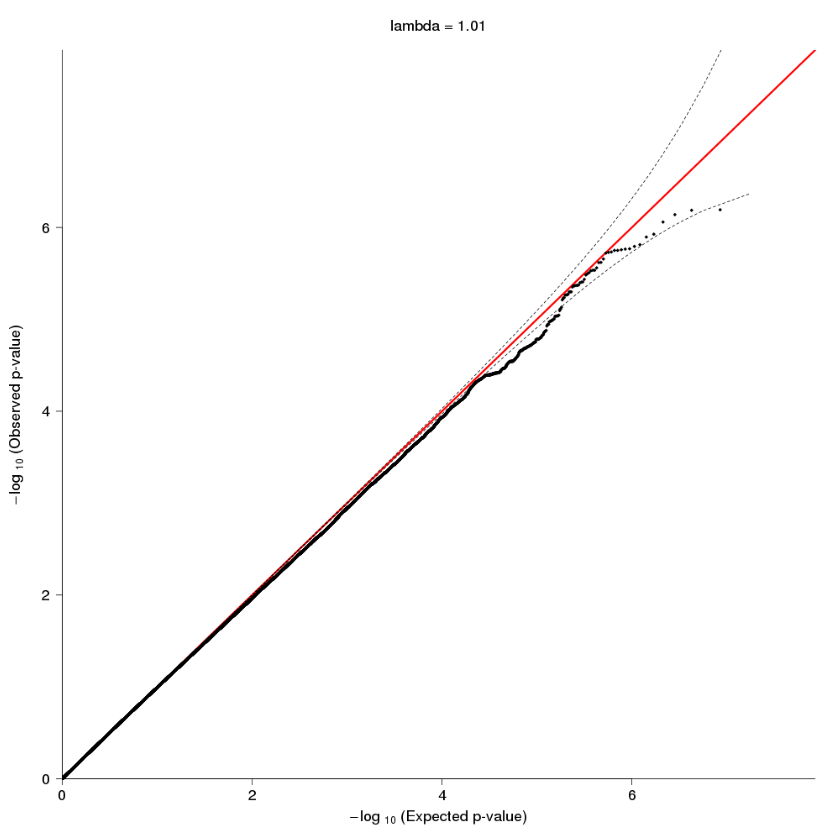

In [2]:
grid::grid.raster(qq)

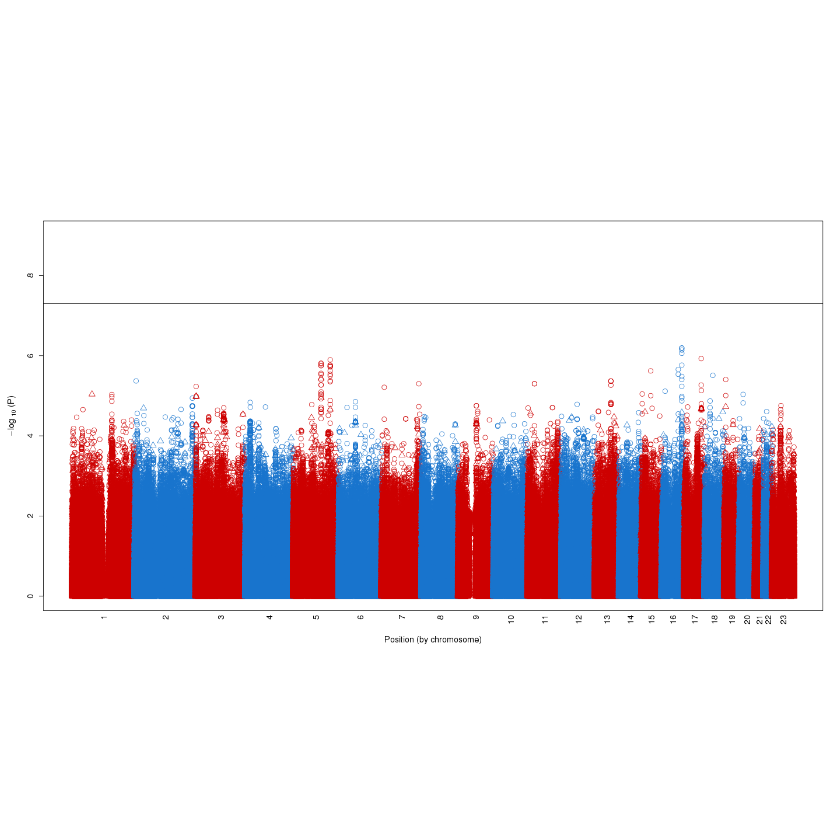

In [3]:
grid::grid.raster(man)

### Sort top P-values

In [ ]:
## Sort in R ##
R
finalD <- "/shared/jmarks/hiv/wihs3/gwas/1df/aa/001/final/"
pfile <- "wihs3.aa.1df.1000G_p3.HIV_ACQ~SNP+AGE+PC3+PC8+PC2.maf_gt_0.01_subject+afr.rsq_gt_0.30.p_lte_0.001"

dat=read.table(paste0(finalD, pfile), header = TRUE)
dat <- dat[order(dat$p),]
write.csv(dat,
          file=paste0(finalD, pfile, ".csv"), row.names = FALSE, quote=F)
## END Filter by p-value ###

# Upload results to S3

In [ ]:
cd /shared/jmarks/hiv/wihs3/gwas/1df/aa/001/
gzip -r * &

aws s3 sync . s3://rti-hiv/wihs3/results/1df/ --quiet &

# Sandbox

In [ ]:
## split the info file and legend
chr=18
split -l 50000 --numeric-suffixes=1 <(tail -n +2 map.chr$chr.legend) map.chr$chr.legend.chunk
split -l 50000 --numeric-suffixes=1 <(tail -n +2 chr$chr.mach.info.pruned) chr$chr.mach.info.pruned.chunk

for file in map.chr$chr.legend.chunk*;do
    echo -e  "id position 0 1" | cat - $file > /tmp/out && mv /tmp/out $file
done

for file in chr$chr.mach.info.pruned.chunk*;do
    echo -e  "SNP\tREF(0)\tALT(1)\tALT_Frq\tMAF\tAvgCall\tRsq" | cat - $file > /tmp/out && mv /tmp/out $file
done


# remove leading zeros 
rename map.chr18.legend.chunk0 map.chr18.legend.chunk map.chr18.legend.chunk0?
rename chr18.mach.info.pruned.chunk0 chr18.mach.info.pruned.chunk chr18.mach.info.pruned.chunk0?

In [ ]:
chr=17
chD=/shared/jmarks/hiv/cfar_coga/genotype/imputed/final/ea/mach/chr17
awk -v ncols=50000 -v chrom=$chr -v chD=$chunkD'
    {
        f=1
        file = chD"/chr"chrom".mach.dose.pruned.chunk" f
        for (i=3; i <= NF; i++) {
            printf "%s%s", $i, OFS > file
            if ((i-2) % ncols == 0) {
                print "" > file
                f++
                file = chD"/chr"chrom".mach.dose.pruned.chunk" f
            }
        }
        print "" > file
    }
    ' $chunkD/chr$chr.mach.dose.pruned

In [ ]:
awk -v ncols=50000 -v chrom=$chr '
    {
        f=1
        file = "chr"chrom".mach.dose.pruned.chunk" f
        for (i=3; i <= NF; i++) {
            printf "%s%s", $i, OFS > file
            if ((i-2) % ncols == 0) {
                print "" > file
                f++
                file = "chr"chrom".mach.dose.pruned.chunk" f
            }
        }
        print "" > file
    } 
    ' /shared/jmarks/hiv/cfar_coga/genotype/imputed/final/ea/mach/chr$chr/chr$chr.mach.dose.pruned &
            

# add the probabel columns (#->ID DOSE)
for file in chr$chr.mach.dose.pruned.chunk*; do
    paste -d " " ../probabel.dose.head $file > /tmp/out && mv /tmp/out $file
done &

In [ ]:
## GWAS ##
for chr in {2..1}; do
    gen=/shared/jmarks/hiv/cfar_coga/genotype/imputed/final/ea/mach/chr$chr
    max=$(ls -l $gen/chr$chr.mach.info.pruned.chunk* | wc -l)

    for ((chunk=1; chunk<=$max; chunk++)); do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name chr$chr.chunk$chunk.probabel.gwas \
            --script_prefix /shared/jmarks/hiv/cfar_coga/gwas/1df/ea/002/processing/chr$chr/chr${chr}_chunk${chunk}_gwas \
            --mem 8 \
            --nslots 7 \
            --program  /shared/bioinformatics/software/third_party/probabel-0.5.0/bin/palogist \
                --pheno  /shared/jmarks/hiv/cfar_coga/phenotype/final/cfar_coga_ea_hiv_age_sex_alcohol_PC1_PC2_PC3_PC4_PC5_PC6_PC7_PC8_PC9_PC10_ordered.txt \
                --dose  $gen/chr${chr}.mach.dose.pruned.chunk$chunk \
                --info  $gen/chr${chr}.mach.info.pruned.chunk$chunk \
                --map   $gen/map.chr${chr}.legend.chunk$chunk \
                --chrom ${chr} \
                --out   /shared/jmarks/hiv/cfar_coga/gwas/1df/ea/002/processing/chr${chr}/chr${chr}.chunk$chunk.palogist.results
    done
done

#grep -L 100.00% *chunk*qsub.log

In [ ]:
### gunzip
for chr in 1; do
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name chr$chr.gunzip \
    --script_prefix chr$chr.gunzip \
    --mem 10 \
    --nslots 7 \
    --program  gunzip chr$chr/*
done

### gzip
for chr in {17..18};do
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name chr$chr.gzip \
    --script_prefix chr$chr.gzip \
    --mem 10 \
    --nslots 7 \
    --program  gzip chr$chr/*
done

### aws download
for chr in {11..14}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr$chr.download \
        --script_prefix chr$chr.download \
        --mem 10 \
        --nslots 7 \
        --program  aws s3 sync s3://rti-hiv/cfar_coga/data/genotype/imputed/final/ea/probabel/chr$chr chr$chr/
done

In [ ]:
## combine chunks
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name combine.chunks \
    --script_prefix combine.chunks \
    --mem 8 \
    --nslots 7 \
    --program  bash combine.sh 

## combine.sh script
procD=/shared/jmarks/hiv/cfar_coga/gwas/1df/ea/001/processing
for chr in {1..22}; do
    max=$(ls -l $procD/chr$chr/chr$chr.chunk*.palogist.results_add.out.txt | wc -l)
    cat $procD/chr$chr/chr$chr.chunk1.palogist.results_add.out.txt > \
        $procD/chr$chr/chr$chr.palogist.results_add.out.txt
    for ((chunk=2; chunk<=$max; chunk++)); do
        tail -n +2 $procD/chr$chr/chr$chr.chunk$chunk.palogist.results_add.out.txt \
            >> $procD/chr$chr/chr$chr.palogist.results_add.out.txt
    done 
done 

In [ ]:
### UHS ###
# merge uhs
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile aa_studies_merged \
    --bmerge ea_studies_merged \
    --make-bed \
    --out uhs1234_merged

# filter to samples with phenotype data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bfile uhs1234_merged \
    --keep keep_ids.txt \
    --make-bed \
    --out uhs1234_merged_filtered

# add sex information
awk 'NR==FNR{map[$3]=$10; next} {if ($5==0) {$5=map[$1]}}1'\
    dbGaP_phenotypeDS_20191202.txt uhs1234_merged_filtered.fam  >\
    uhs1234_merged_filtered_sex_added.fam


/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --bed uhs1234_merged_filtered.bed \
    --bim uhs1234_merged_filtered.bim \
    --fam uhs1234_merged_filtered_sex_added.fam \
    --make-bed \
    --out uhs1234_final_genotype